In [60]:
# Importing neccessary libraries
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model



In [27]:
# Downloading nltk stopwords and tokenizer
nltk.download('stopwords')
nltk.download('punkt')


# Setting the base directory for your project
base_dir = r"D:\Project"

# Setting the path for the text dataset folder
text_dataset_dir = os.path.join(base_dir, "dataset for terror text")

# Loading train and test CSV files
train_csv_path = os.path.join(text_dataset_dir, "train.csv")
test_csv_path  = os.path.join(text_dataset_dir, "test.csv")

# Reading the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# The CSV files have column names with extra quotes, so let's remove them..
train_df.columns = [col.strip().replace('"', '') for col in train_df.columns]
test_df.columns = [col.strip().replace('"', '') for col in test_df.columns]

#Printing the details
print("TRAIN CSV Info:")
print(train_df.info())
print("\nTRAIN CSV First 5 Rows:")
print(train_df.head())

print("\nTEST CSV Info:")
print(test_df.info())
print("\nTEST CSV First 5 Rows:")
print(test_df.head())




TRAIN CSV Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      400 non-null    object
 1   tweet   400 non-null    object
 2   class   400 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 9.5+ KB
None

TRAIN CSV First 5 Rows:
                   id                                              tweet  \
0  746007323479576576  عاجل | مصادر عراقية: 20 قتيلا بينهم قائد للحشد...   
1  569488484957855745  RT @Iraq_now2: نحو٣٠٠عنصر من عصابات"حزب الله"ا...   
2  664157183135870976                     @DroopDelaCreme you knowwwwwww   
3  561386715349536768  @_AbDwd2 bro, I really wish twitter would dele...   
4  553368348361490432  When a coconut gets asked if he supports ISIS ...   

   class  
0      1  
1      1  
2      1  
3      1  
4      1  

TEST CSV Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data colum

[nltk_data] Downloading package stopwords to C:\Users\Aman
[nltk_data]     Sinha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Aman
[nltk_data]     Sinha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
train_df.head()

,id,tweet,class
0,746007323479576576,عاجل | مصادر عراقية: 20 قتيلا بينهم قائد للحشد...,1
1,569488484957855745,"RT @Iraq_now2: نحو٣٠٠عنصر من عصابات""حزب الله""ا...",1
2,664157183135870976,@DroopDelaCreme you knowwwwwww,1
3,561386715349536768,"@_AbDwd2 bro, I really wish twitter would dele...",1
4,553368348361490432,When a coconut gets asked if he supports ISIS ...,1


In [38]:
# Define text preprocessing function that preserves Arabic characters (Unicode range \u0600-\u06FF)
import nltk
nltk.download('all')


def preprocess_text(text):
    # Convert text to string in case of missing values
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Keep Arabic letters (\u0600-\u06FF), English letters, digits, and whitespace.
    text = re.sub(r'[^\u0600-\u06FFa-z0-9\s]', ' ', text)
     # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    # Here, we remove English stopwords.
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    return ' '.join(filtered_tokens)

# Update the cleaned text columns in both train and test DataFrames.
train_df['clean_text'] = train_df['tweet'].apply(preprocess_text)
test_df['clean_text'] = test_df['tweet'].apply(preprocess_text)

# Display the updated samples from train_df
print("\nCleaned Text Samples (Train):")
print(train_df['clean_text'].iloc[0])
print(train_df['clean_text'].iloc[1])
print(train_df['clean_text'].iloc[2])
print(train_df['clean_text'].iloc[3])
print(train_df['clean_text'].iloc[19])


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\Aman
[nltk_data]    |     Sinha\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to C:\Users\Aman
[nltk_data]    |     Sinha\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Aman Sinha\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Aman Sinha\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Aman Sinha\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nl


Cleaned Text Samples (Train):
عاجل مصادر عراقية 20 قتيلا بينهم قائد للحشد العشائري في هجوم لتنظيم الدولة بالأنبار
rt iraq now2 نحو٣٠٠عنصر من عصابات حزب الله اللبناني يتواجدون في العراق لدعم العصابات الشيعية https co m6olu9lswp http co eqxa7uqzv1
droopdelacreme knowwwwwww
abdwd2 bro really wish twitter would delete retards like rather dawlah supporters guy needs bullet http co om2359dsb0
keep tuhin mustakeem abu nusaybah ad iyah including muslim prisoners may allaah hasten release ameen


In [40]:
#TF-IDF Vectorization and Data Preparation

# Initializing TF-IDF Vectorizer (we have set max_features to 5000)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform on training cleaned text; transform the test text.
X_train = vectorizer.fit_transform(train_df['clean_text']).toarray()
X_test = vectorizer.transform(test_df['clean_text']).toarray()

# The labels are in the "class" column
y_train = train_df['class']
y_test = test_df['class']

print("TF-IDF feature matrix shape (Train):", X_train.shape)
print("TF-IDF feature matrix shape (Test):", X_test.shape)


TF-IDF feature matrix shape (Train): (400, 3435)
TF-IDF feature matrix shape (Test): (100, 3435)


In [41]:
# Training a Naïve Bayes Model on the Text Data


# Initializing and traiming the Naïve Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = nb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Naïve Bayes Text Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Naïve Bayes Text Model Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78        50
           1       0.80      0.72      0.76        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



In [42]:
'''The Naïve Bayes model achieved 77% accuracy, with balanced precision and recall.It performs slightly better on non-terrorist texts (82% recall) but struggles with terrorist texts (72% recall)'''

'The Naïve Bayes model achieved 77% accuracy, with balanced precision and recall.It performs slightly better on non-terrorist texts (82% recall) but struggles with terrorist texts (72% recall)'

In [44]:
#Training a Neural Network for Text Classification



# Defining the input layer explicitly using the Functional API
inputs = Input(shape=(X_train.shape[1],))  # X_train.shape[1] is the number of features

# Building the model layers
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # For binary classification


# Creating the model
text_nn_model = Model(inputs=inputs, outputs=outputs)

# Compiling the model
text_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = text_nn_model.fit(X_train, y_train, epochs=10, batch_size=34, validation_data=(X_test, y_test))

# Evaluating the model on the test set
loss, acc = text_nn_model.evaluate(X_test, y_test)
print("Neural Network Text Model Accuracy: {:.2f}%".format(acc * 100))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4611 - loss: 0.6944 - val_accuracy: 0.5100 - val_loss: 0.6861
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7909 - loss: 0.6562 - val_accuracy: 0.7700 - val_loss: 0.6617
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9767 - loss: 0.5581 - val_accuracy: 0.8000 - val_loss: 0.5784
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9934 - loss: 0.2791 - val_accuracy: 0.7600 - val_loss: 0.5116
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9996 - loss: 0.0544 - val_accuracy: 0.7600 - val_loss: 0.5712
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.7500 - val_loss: 0.6864
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7500 - val_loss: 0.7446
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7600 - v

In [45]:
'''The Neural Network model achieved 76% accuracy, slightly lower than Naïve Bayes. This suggests it may need more training data, better tuning, or handling of class imbalances for improved performance.'''

'The Neural Network model achieved 76% accuracy, slightly lower than Naïve Bayes. This suggests it may need more training data, better tuning, or handling of class imbalances for improved performance.'

In [46]:
#Saving the Text model
import joblib
from tensorflow.keras.models import load_model

# Save the Naïve Bayes model
joblib.dump(nb_model, r"D:\Project\naive_bayes_text_model.pkl")

# Save the Neural Network text model
text_nn_model.save(r"D:\Project\text_nn_model.keras")

# Save the TF-IDF Vectorizer (needed for text preprocessing during inference)
joblib.dump(vectorizer, r"D:\Project\tfidf_vectorizer.pkl")

print(" Text models and vectorizer saved successfully!")


 Text models and vectorizer saved successfully!


In [47]:
#Load the Saved Models for Inference
# Load the Naïve Bayes model
nb_model_loaded = joblib.load(r"D:\Project\naive_bayes_text_model.pkl")

# Load the Neural Network model
text_nn_model_loaded = load_model(r"D:\Project\text_nn_model.keras")

# Load the TF-IDF Vectorizer
vectorizer_loaded = joblib.load(r"D:\Project\tfidf_vectorizer.pkl")

print(" Models successfully loaded!")


 Models successfully loaded!


In [48]:
# Example text for prediction
new_text = "Kill Rahul Gandhi today"

# Preprocess using the loaded TF-IDF vectorizer
new_text_vectorized = vectorizer_loaded.transform([new_text]).toarray()

# Predict using Naïve Bayes
nb_prediction = nb_model_loaded.predict(new_text_vectorized)[0]

# Predict using Neural Network
nn_prediction = text_nn_model_loaded.predict(new_text_vectorized)[0][0]

# Display Results
print("Naïve Bayes Prediction:", "Terrorist" if nb_prediction == 1 else "Non-Terrorist")
print("Neural Network Prediction:", "Terrorist" if nn_prediction > 0.8 else "Non-Terrorist")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Naïve Bayes Prediction: Terrorist
Neural Network Prediction: Terrorist


In [49]:
# CNN Model for images

Files in sample folder: ['2an91r9.jpg', '2b7cyp2.jpg', '2b7cypm.jpg', '2bag6x8.jpg', '2bd6ytp.jpg']


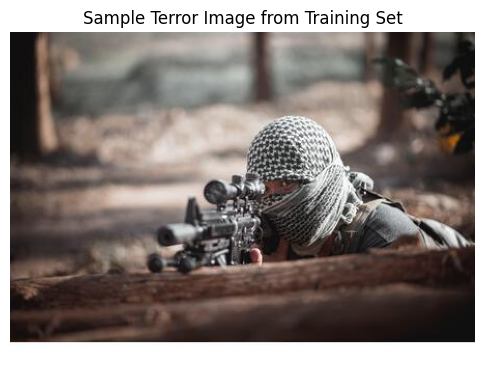

In [50]:


# Setting the base image dataset directory
img_dataset_dir = r"D:\Project\dataset for terror image"

# Defining the training set folder and sample folder (e.g., terror)
train_dir = os.path.join(img_dataset_dir, "training_set")
sample_folder = os.path.join(train_dir, "terror")  

# Listing files in the sample folder
sample_images = os.listdir(sample_folder)
print("Files in sample folder:", sample_images[:5])  # It will show first 5 files

# Picking any image and displaying it
sample_img_path = os.path.join(sample_folder, sample_images[29])
sample_img = cv2.imread(sample_img_path)
if sample_img is None:
    print("Error: Could not load the image. Check the file path.")
else:
    # Convert BGR (OpenCV default) to RGB for display
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(sample_img_rgb)
    plt.title("Sample Terror Image from Training Set")
    plt.axis("off")
    plt.show()


In [51]:
#Setting Up Image Data Generators


# Defining parameters
IMG_SIZE = 128  # Resize images to 128x128
batch_size = 32

# Setting the path to our training set directory
train_dir = os.path.join(r"D:\Project\dataset for terror image", "training_set")

# Creating an ImageDataGenerator with rescaling and augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Using 20% of the training data for validation
    rotation_range=30,      # Rotate images randomly by up to 30 degrees
    width_shift_range=0.2,  # Shift images horizontally by 20%
    height_shift_range=0.2, # Shift images vertically by 20%
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Zooming transformation
    horizontal_flip=True,   # Flipping images horizontally
    fill_mode='nearest'     # Filling in new pixels with nearest mode
)

# Validation generator (No augmentation, just rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Creating a training generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',  # We are assuming two classes: terror and persons
    subset='training'
)

# Creating a validation generator
validation_generator = validation_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Print out of the class indices to verify (will  show something like: {'persons': 0, 'terror': 1})
print("Class Indices:", train_generator.class_indices)


Found 479 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Class Indices: {'person': 0, 'terror': 1}


In [52]:


# Build the CNN model using an Input layer
cnn_model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: terror vs person
])

# Displaying the model summary 
cnn_model.summary()

# Compiling the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Before it was 10 got the accuracy as 89.93% no have Increased from 10 to 20
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = cnn_model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(val_acc * 100))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Aman Sinha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - accuracy: 0.5063 - loss: 0.7628 - val_accuracy: 0.5593 - val_loss: 0.7236
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.5808 - loss: 0.6764 - val_accuracy: 0.6864 - val_loss: 0.5863
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.7424 - loss: 0.5901 - val_accuracy: 0.7458 - val_loss: 0.5192
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.7608 - loss: 0.5108 - val_accuracy: 0.8559 - val_loss: 0.4083
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.8021 - loss: 0.4668 - val_accuracy: 0.8136 - val_loss: 0.4478
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.8253 - loss: 0.4311 - val_accuracy: 0.8644 - val_loss: 0.3476
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.8235 - loss: 0.4198 - val_accuracy: 0.8814 - val_loss: 0.3026
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.8141 - loss: 0.4411 - val_accuracy: 0.8729 - val_loss:

In [54]:
#Our CNN model shows strong learning progress, with validation accuracy reaching 94.07%%. The steady accuracy improvements and lower validation loss indicate that the model is effectively capturing patterns. 

In [55]:
#Saving the model
cnn_model.save(r"D:\Project\cnn_image_model.keras")

In [56]:
# Evaluating on Test Data
# Create a test data generator (if not already created)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(r"D:\Project\dataset for terror image", "test_set"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary'
)

# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))


Found 73 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8113 - loss: 0.4700
Test Accuracy: 79.45%


In [57]:

'''Our CNN model evaluation on the test dataset shows promising results. Achieving a test accuracy of 79.45 indicates strong performance. '''

'Our CNN model evaluation on the test dataset shows promising results. Achieving a test accuracy of 79.45 indicates strong performance. '

In [58]:
#Saving the Model for Future Use
cnn_model.save(r"D:\Project\cnn_image_model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


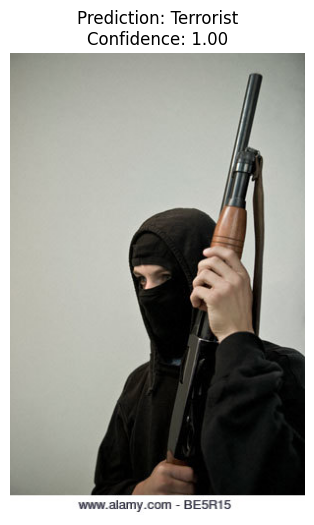

In [62]:

# Loading the trained model
model = load_model(r"D:\Project\cnn_image_model.keras")

# Function to preprocess and predict an image, then display it
def predict_and_show_image(image_path):
    # Loading and preprocessing the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (for correct colors in matplotlib)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to model input size
    img_normalized = img_resized / 255.0  # Normalize pixel values
    img_expanded = np.expand_dims(img_normalized, axis=0)  # Adding batch dimension

    # Make the prediction
    prediction = model.predict(img_expanded)[0][0]
    label = "Terrorist" if prediction > 0.5 else "Non-Terrorist"

    # Showing the image with the prediction label
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {label}\nConfidence: {prediction:.2f}")  
    plt.axis("off")
    plt.show()

# Example usage
image_path = r"D:\Project\dataset for terror image\test_set\terror\t1811.jpg"  # We can Modify the path accordingly
predict_and_show_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


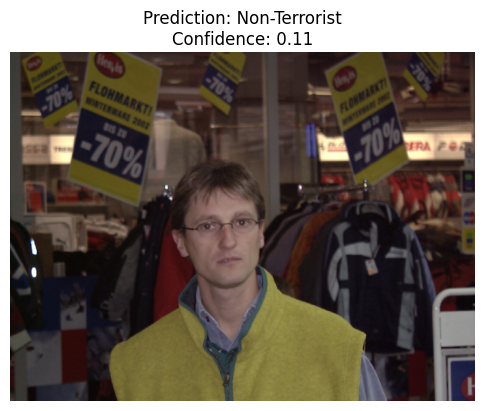

In [64]:

# Loading the trained model again got the person prediction
model = load_model(r"D:\Project\cnn_image_model.keras")

# Function to preprocess and predict an image, then display it
def predict_and_show_image(image_path):
    # Loading and preprocessing the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (for correct colors in matplotlib)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to model input size
    img_normalized = img_resized / 255.0  # Normalize pixel values
    img_expanded = np.expand_dims(img_normalized, axis=0)  # Adding batch dimension

    # Make the prediction
    prediction = model.predict(img_expanded)[0][0]
    label = "Terrorist" if prediction > 0.5 else "Non-Terrorist"

    # Showing the image with the prediction label
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {label}\nConfidence: {prediction:.2f}")  
    plt.axis("off")
    plt.show()

# Example usage
image_path = r"D:\Project\dataset for terror image\test_set\persons\person_157.bmp"  # We can Modify the path accordingly 
predict_and_show_image(image_path)
